# R


- 기존 feed forward 방식에서 시계열 데이터의 성질(패턴)을 충분히 학습하기 위해 RNN(Recurrent Neural Network) 도입.

## 확률과 언어 모델

- CBOW 모델의 목적 : 맥락(context)으로부터 타깃(target)을 정확하게 추측하는 것
- 언어 모델(Language Model) : 단어 나열에 확률을 부여함.
    - 단어의 sequence가 일어날 가능성이 어느정도인지 확률로 평가.(얼마나 자연스러운 단어 순서인지)
    - t-1번째 까지의 단어가 나왔을 때, t번째 단어가 나올 확률을 계산하여(조건부 언어 모델, Conditional Language Model) 동시 확률을 구함
    - Markov Chain을 통해 확률 근사
<br/> <img src='../figs/e%205-8.png'> <br/>

- CBOW(Continuous Bag-Of-Words)는 '가방안에 들어 있는 단어들'이라는 이름에서 알 수 있듯이 가방 속의 단어의 순서는 무시함.
- 위 언어모델 확률 계산에서, 맥락의 크기를 고정하여(위의 경우 2) 확률을 근사했는데, CBOW의 경우 맥락의 크기 밖의 정보를 무시하는 문제가 발생함.
<br/> <img src='../figs/fig%205-5.png'> <br/>
- CBOW는 왼쪽 그림과 같이 단어 벡터들이 더해지면서 단어의 순서가 무시됨
- 신경 확률론적 언어모델(Neural Probablistic Language Model)에서는 오른쪽 그림과 같이 단어를 더하는 대신 연결(concatenate)하는 방식을 사용
- 이 때 W의 parameter가 늘어나는 문제를 RNN을 사용하여 해결!

## RNN

- 앞서 만들었던 단어의 분산 표현($x_t$)을 순서대로 RNN layer에 입력
<br/> <img src='../figs/fig%205-8.png'> <br/>
- 각 hidden layer에서 두 input을 바탕으로 output 계산
<br/> <img src='../figs/e%205-9.png'> <br/>
- 이때 $t$번째, '시각 $t$'에서의 출력 $h_t$를 은닉 상태($hidden~state$)라고 함

### BPTT

- BPTT(Backpropagation Through Time) : 시간 방향으로 펼친 신경망의 오차역전파법
<br/> <img src='../figs/fig%205-10.png'> <br/>
- 그러나 BPTT을 이용할 때, 계산량 뿐만 아니라 RNN layer 중간 데이터를 메모리에 유지해 두어야 하기 때문에 메모리 사용량도 증가

### Truncated BPTT

- 길어진 신경망 연결을 적당한 길이로 끊어서 계산량을 줄임
- layer가 많아지면서 기울기 값이 점점 작아져서 0에 가까워지는 문제도 해결
- forward propagation은 유지하고 backward의 연결만 적당한 길이로 끊어야 함
<br/> <img src='../figs/fig%205-11.png'> <br/>
- RNN 학습시에 forward propagation를 순서대로 수행하고 그 다음 backward propagaion을 수행함
- 그러므로 기존 신경망에서 미니배치 학습을 수행할 떄 데이터를 무작위로 선택했던 것과 다르게 데이터를 순서대로 입력해야 함.

### Mini-batch

- 랜덤하게 미니 배치를 선택했던 것과 다르게 데이터를 순서대로 입력해야함.
- 각 미니배치마다 시작 위치를 batch-size만큼 옮겨줘야 함

## 구현

- 길이가 T인 시계열 데이터를 받아서, 각 시각의 hidden state T개를 출력.
- 이때 입력($xs$), 출력($hs$)를 묶은 layer를 Time RNN layer라고 함
<br/> <img src='../figs/fig%205-17.png'> <br/>

In [15]:
# RNN layer
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev
        

### Time RNN

- stateful(True/False) : Time RNN이 hidden state를 유지할지

In [16]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx
            
            for i, grad in enumerate(grads):
                self.grads[i][...] = grad
            self.dh = dh
            
        return dxs
        
    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None
    

### RNNLM(RNN Language Model)

1. 문장을 단어의 단어들을 단어의 분산 표현(vector)로 변환
2. 해당 vector들을 순서대로 RNN layer에 입력
3. RNNLM은 지금까지 입력된 단어를 기억하고 다음에 출현할 단어를 예측
<br/> <img src='../figs/fig%205-25.png'> <br/>

### Time layers

- 각 layer 종류 XX마다 Time XX layer를 구현
    - Time Affine
    - Time Embedding
    - Time Softmax with Loss : T개의 Softmax with Loss layer 각각의 loss를 평균
    - Time Sigmoid with Loss

In [3]:
import numpy as np
import sys
sys.path.append('..')
from common.layers import *
from common.funcs import cross_entropy_error, softmax, sigmoid

- Time Affine

In [4]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        dW = np.dot(rx.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

- Time Embedding

In [5]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        output = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            output[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
        
        return output
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
            
        self.grads[0][...] = grad
        return None

- Time Softmax with Loss

In [30]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        if ts.ndim == 3: # 정답 label이 one-hot vector일 때
            ts = ts.argmax(axis=2)
        
        # ignore_label에 해당하는 데이터 처리
        mask = (ts != self.ignore_label)
        
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)
        
        ys = softmax(xs)
        ls = mask * np.log(ys[np.arange(N * T), ts]) # ignore_label에 해당하는 데이터 손실 0으로 처리
        loss = -np.sum(ls) / mask.sum()
        
        self.cache = (ts, ys, mask, (N, T, V))
        
        return loss
        
    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        
        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx = dx * dout / mask.sum()
        dx *= mask[:, np.newaxis] # ignoer_label에 해당하는 데이터 기울기를 0으로
        
        dx = dx.reshape((N, T, V))
        
        return dx

- Time Sigmoid with Loss

In [31]:
class TimeSigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.xs_shape = None
        self.layers= None

    def forward(self, xs, ts):
        N, T = xs.shape
        self.xs_shape = xs.shape
        
        self.layers = []
        loss = 0
        
        for t in range(T):
            layer = SigmoidWithLoss()
            loss += layer.forward(xs[:, t], ts[:, t])
            self.layers.append(layer)
            
        return loss/T

    def backward(self, dout=1):
        N, T = self.xs_shape
        dxs = np.empty(self.xs_shape, dtype='f')
        
        dout /= T
        
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t] = layer.backward(dout)
            
        return dxs

### RNNLM 구현

- SimpleRnnlm : 아래와 같이 4개의 time layer를 쌓은 신경망
<br/> <img src = '../figs/fig%205-30.png' width='300px'> <br/>
- Xavier initialization : 이전 layer의 노드의 개수($n$)을 사용해 표준편차가 $1 \over \sqrt n$인 분포로 initialize
    - non-linear(tanh, sigmoid 등)에서 좋은 성능
    - ReLU의 경우 출력값이 0으로 수렴하는 문제가 있음

In [23]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # initialize weight(Xavier)
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # layer 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # list
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
        
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
            
        return dout
    
    def reset_state(self):
        '''
        hidden state 초기화
        '''
        self.rnn_layer.reset_state()

## 평가

### perplexity

- '확률의 역수' : 값이 낮을수록 언어 모델의 예측 성능이 좋은 모델
- $perplexity = e^L =  exp~(- {1 \over N} \sum\limits_{n} \sum\limits_{k} t_{nk}~log y_{nk})$
- $N$ : 데이터의 총 개수, $t_n$ : 정답 레이블, $t_{nk}$ : n개째 데이터의 k번째 값, $y_{nk}$ : 확률분포
- 위 값들을 통해 계산한 $L$ 은 Cross-entroy error를 통해 계산한 신경망의 손실과 같음

In [24]:
def perplexity():
    d

## 학습

In [25]:
import matplotlib.pyplot as plt
from common.optimizer import SGD
from data import ptb

In [40]:
# hyperparameter 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 hidden state의 벡터의 길이
time_size = 5 # Truncated BPTT가 한번에 펼치는 시간의 길이
lr = 0.1
max_epoch = 100

In [41]:
# data load
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1]
ts = corpus[1:]
data_size = len(xs)
print(f'corpus size : {corpus_size}, vocab size : {vocab_size}')

# 변수 설정
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

corpus size : 1000, vocab size : 418


In [42]:
# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

- 학습

In [43]:
# 각 mini-batch에서 샘플을 읽는 시작 위치 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

# 각 epoch, iter마다 순차적으로
for epoch in range(max_epoch):
    for iters in range(max_iters):
        # mini-batch 생성
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
            
        # 기울기 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
    
    # 각 epoch마다 평가(perplexity)
    ppl = np.exp(total_loss / loss_count)
    print(f'| epoch : {epoch + 1} | perplexity : {ppl} |')
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

| epoch : 1 | perplexity : 414.6209755862757 |
| epoch : 2 | perplexity : 406.1885653513905 |
| epoch : 3 | perplexity : 395.4628658685468 |
| epoch : 4 | perplexity : 378.35236129675485 |
| epoch : 5 | perplexity : 366.1856170157493 |
| epoch : 6 | perplexity : 354.191880975869 |
| epoch : 7 | perplexity : 344.57856882471776 |
| epoch : 8 | perplexity : 331.4737590365354 |
| epoch : 9 | perplexity : 318.2593743052612 |
| epoch : 10 | perplexity : 305.9840191114381 |
| epoch : 11 | perplexity : 292.81834082706536 |
| epoch : 12 | perplexity : 281.54935074136347 |
| epoch : 13 | perplexity : 269.83657105525566 |
| epoch : 14 | perplexity : 258.98942684398656 |
| epoch : 15 | perplexity : 248.69355655552775 |
| epoch : 16 | perplexity : 236.7400486161392 |
| epoch : 17 | perplexity : 224.27638588249593 |
| epoch : 18 | perplexity : 213.92731151485285 |
| epoch : 19 | perplexity : 205.62306209405713 |
| epoch : 20 | perplexity : 200.49764476537203 |
| epoch : 21 | perplexity : 193.6602118

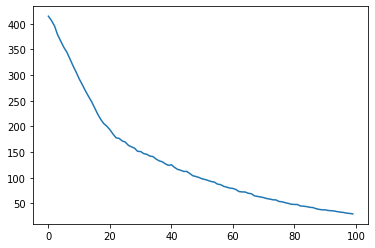

In [44]:
plt.plot(ppl_list)